# パッケージインストール

In [1]:
!pip install -q git+https://github.com/huggingface/transformers accelerate
!pip install -q qwen-vl-utils[decord]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.0/515.0 kB 26.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 142.5 MB/s eta 0:00:00


# サンプル画像ダウンロード

In [2]:
!wget https://raw.githubusercontent.com/Kazuhito00/Qwen3-VL-Colaboratory-Sample/refs/heads/main/sample.jpg -O sample.jpg

--2025-11-13 01:16:31--  https://raw.githubusercontent.com/Kazuhito00/Qwen3-VL-Colaboratory-Sample/refs/heads/main/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133381 (130K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 130.25K  --.-KB/s    in 0.002s  

2025-11-13 01:16:31 (65.1 MB/s) - ‘sample.jpg’ saved [133381/133381]



# モデル読み込み

In [3]:
# モデル選択
# model_path = "Qwen/Qwen3-VL-2B-Instruct"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-2B-Thinking"  # T4 GPU
model_path = "Qwen/Qwen3-VL-4B-Instruct"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-4B-Thinking"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-8B-Instruct"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-8B-Thinking"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-32B-Instruct"  # A100 GPU
# model_path = "Qwen/Qwen3-VL-32B-Thinking"  # A100 GPU
# model_path = "Qwen3-VL-30B-A3B-Instruct"  # A100 GPU
# model_path = "Qwen3-VL-30B-A3B-Thinking"  # A100 GPU
# model_path = "Qwen3-VL-235B-A22B-Instruct"  # A100 GPU
# model_path = "Qwen3-VL-235B-A22B-Thinking"  # A100 GPU

In [4]:
from transformers import Qwen3VLForConditionalGeneration, AutoTokenizer, AutoProcessor

model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

# プロンプト生成

In [5]:
from qwen_vl_utils import process_vision_info

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "sample.jpg"},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 推論

In [6]:
%%time

generated_ids = model.generate(**inputs, max_new_tokens=4096)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

CPU times: user 51.3 s, sys: 468 ms, total: 51.7 s
Wall time: 53 s


# 結果確認

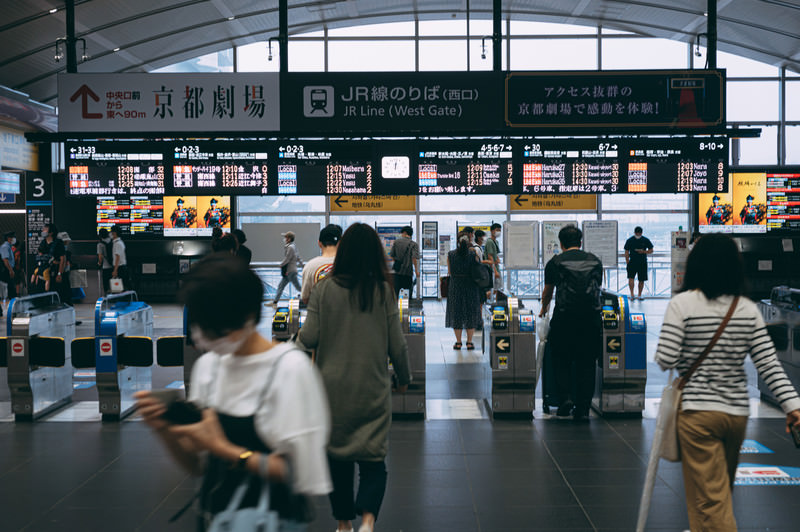

In [7]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('sample.jpg')
cv2_imshow(image)

In [8]:
import textwrap

print(textwrap.fill(output_text[0], width=50))

この画像は、日本の駅（おそらく京都駅）の改札口付近を捉えたもので、多くの人々が行き交う様子が写ってい
ます。  ### 主な要素：  - **駅の構造と看板**：   - 画像の上部には大きな案内表示板
があり、「京都劇場」や「JR線のりば（西口）」などの文字が見えます。これはJR西日本の駅で、京都駅の
西口付近であることを示しています。   -
「アクセス抜群の京都劇場で体験！」という宣伝文も見られます。  - **電光掲示板**：   - 改
札の背後には、複数の電光掲示板があり、各列車の到着・出発時刻や駅名、列車番号が表示されています。日本
語と英語で情報が提示されており、観光客や通勤者にとって非常に役立つものです。  -
**人々の様子**：   -
画像には、多くの人々が写っており、それぞれが自分の目的地に向かって移動しています。   - 一部の人
はマスクを着用しており、これはCOVID-19の流行期（2020年代初頭）の様子を示唆しています。
- 人々の動きは活発で、それぞれが自分のスケジュールに合わせて移動している様子がうかがえます。  -
**改札口**：   - 改札口は自動改札機で、人々が通過している様子が写っています。改札機のデザイ
ンは現代的で、スムーズな通過を可能にするよう設計されています。  - **雰囲気**：   - 画像
全体には、都会的な活気と秩序が感じられます。駅の広さと明るさ、人々の動きから、大都市の交通の中心地で
あることが伝わってきます。  ### 結論：  この画像は、日本の都市駅の日常的な光景を捉えたもので
、人々の移動と交通の流れを描いています。特に「京都駅」の西口付近という場所は、観光客や通勤者にとって
重要な交通拠点であり、その活気ある様子が写し出されています。  ---  **補足**： 画像の右上
には「アクセス抜群の京都劇場で体験！」という文字があり、これは京都駅の西口から京都劇場へ行くアクセス
の良さをアピールしている可能性があります。これは観光客向けの宣伝であり、駅の機能性と観光資源の連携を
示しています。


# プロンプト生成

In [9]:
from qwen_vl_utils import process_vision_info

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "sample.jpg"},
            {"type": "text", "text": "物体検出でマスクをかけた人物を検出してください。バウンディングボックス座標とラベル名はJSON形式で出力してください。JSONのラベル名は英語で出力してください。"},
        ],
    }
]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 推論

In [10]:
%%time

generated_ids = model.generate(**inputs, max_new_tokens=16384)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

CPU times: user 23.9 s, sys: 346 ms, total: 24.2 s
Wall time: 24.2 s


# 結果確認

In [11]:
import textwrap

print(output_text[0])

```json
[
	{"bbox_2d": [167, 480, 419, 999], "label": "Masked person"},
	{"bbox_2d": [119, 425, 152, 550], "label": "Masked person"},
	{"bbox_2d": [556, 436, 604, 659], "label": "Masked person"},
	{"bbox_2d": [669, 421, 756, 789], "label": "Masked person"}
]
```


In [12]:
import copy
import json
import re
import cv2
import random


def draw_bboxes_from_json_str(json_str: str, image):
    # ```json ～ ``` の中を抽出
    match = re.search(r"```json(.*?)```", json_str, flags=re.DOTALL)
    if not match:
        raise ValueError("JSON が ```json ... ``` の形式で見つかりません")

    json_body = match.group(1)

    # JSON をパース
    try:
        data = json.loads(json_body)
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON パースエラー: {e}")

    debug_image = copy.deepcopy(image)

    # ---- ラベルごとの色定義 ----
    # 必要に応じて追加
    label_colors = {
        "person":     (0, 255, 0),     # green
        "car":        (0, 0, 255),     # red
    }

    # 未登録ラベルの色を保持（毎回ランダム生成し、同じラベルは同じ色を使う）
    random_color_cache = {}

    def get_color(label: str):
        if label in label_colors:
            return label_colors[label]

        if label not in random_color_cache:
            random_color_cache[label] = (
                random.randint(50, 255),
                random.randint(50, 255),
                random.randint(50, 255)
            )
        return random_color_cache[label]

    # 描画
    for obj in data:
        bbox = obj["bbox_2d"]
        label = obj["label"]

        height, width = image.shape[:2]

        # x1, y1, x2, y2   (0-1000 正規化 → pixel)
        x1 = int(bbox[0] / 1000 * width)
        y1 = int(bbox[1] / 1000 * height)
        x2 = int(bbox[2] / 1000 * width)
        y2 = int(bbox[3] / 1000 * height)

        # ラベルごとの色
        color = get_color(label)

        # bbox
        cv2.rectangle(debug_image, (x1, y1), (x2, y2), color, 2)

        # label
        cv2.putText(
            debug_image,
            label,
            (x1, y1 - 4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.75,
            color,
            2
        )

    return debug_image

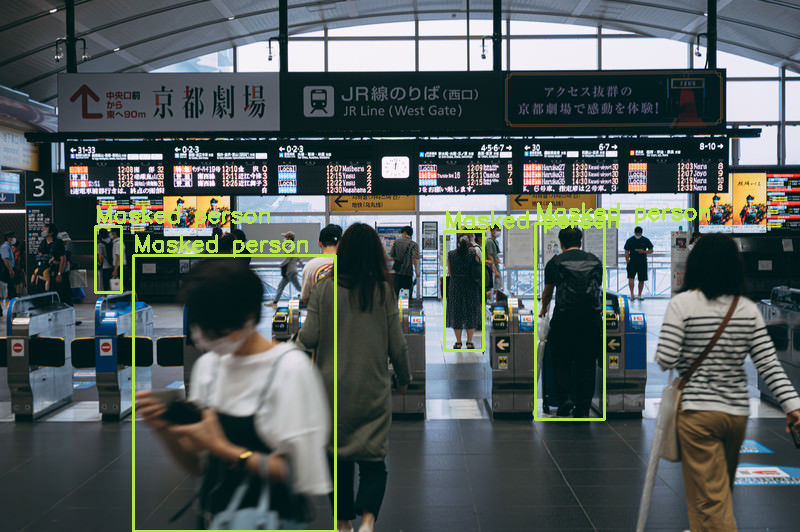

In [13]:
debug_image = draw_bboxes_from_json_str(output_text[0], image)

cv2_imshow(debug_image)